# Researcher Agent v5 - Extended with Tools

Enhanced version of the research agent workflow that includes:
1. Planning sections based on user query
2. Finding relevant web sources for each section
3. Downloading and processing content
4. Generating comprehensive blog post sections
5. **NEW**: Human review and editing phase
6. **NEW**: Tool usage (emoji replacement and code execution)


## Configuration and Setup

In [24]:
# Configuration constants
MAX_SOURCES_PER_SECTION = 2
REQUEST_TIMEOUT = 300
CONTEXT_WINDOW = 80000
MODEL_NAME = "qwen2:7b"

In [25]:
# Core imports
import urllib.request
import urllib.error
import subprocess
import tempfile
import os
import re
from typing import TypedDict, Optional, Annotated, List
from datetime import datetime
from bs4 import BeautifulSoup

# LangChain imports
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage
from llama_index.core.base.llms.types import MessageRole
from llama_index.core.base.llms.base import ChatMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END

# LLM imports
from llama_index.llms.ollama import Ollama
from llama_index.core.chat_engine import SimpleChatEngine
from ddgs import DDGS

# Display imports
from IPython.display import Image, display

In [26]:
# Initialize LLM
llm = Ollama(
    model=MODEL_NAME, 
    context_window=CONTEXT_WINDOW, 
    request_timeout=REQUEST_TIMEOUT
)

# Create a ChatEngine
chat_model = SimpleChatEngine.from_defaults(llm=llm)

# Test connection
test_response = chat_model.chat("Hello")
print(f"Model initialized: {test_response.response[:50]}...")

Model initialized: Hello! How can I help you today? Let me know if yo...


## Utility Functions

In [27]:
def extract_text_from_html(raw_html: str) -> str:
    """
    Extract clean text from raw HTML using BeautifulSoup.
    
    Args:
        raw_html (str): Raw HTML content
        
    Returns:
        str: Extracted clean text
    """
    try:
        soup = BeautifulSoup(raw_html, 'html.parser')
        
        # Remove unwanted elements
        for element in soup(["script", "style", "nav", "footer", "header", "aside"]):
            element.decompose()
        
        # Extract and clean text
        text = soup.get_text()
        
        # Clean whitespace
        lines = (line.strip() for line in text.splitlines())
        chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
        cleaned_text = ' '.join(chunk for chunk in chunks if chunk)
        
        return cleaned_text
    except Exception as e:
        print(f"Error extracting text from HTML: {e}")
        return ""

In [28]:
def parse_sections_list(llm_response: str) -> List[str]:
    """
    Parse LLM response to extract section list.
    
    Args:
        llm_response (str): Raw LLM response containing section list
        
    Returns:
        List[str]: Parsed sections
    """
    try:
        # Remove brackets and split by comma
        cleaned = llm_response.strip().strip('[]')
        sections = [section.strip().strip('"').strip("'") for section in cleaned.split(',')]
        return [section for section in sections if section]
    except Exception as e:
        print(f"Error parsing sections: {e}")
        return []

## Tool Functions

In [29]:
def add_emojis_tool(text: str) -> str:
    """
    Tool that replaces :smile: patterns with actual emoji characters.
    
    Args:
        text (str): Input text with emoji patterns
        
    Returns:
        str: Text with emojis replaced
    """
    # Define emoji mappings
    emoji_mappings = {
        ':smile:': '😊',
        ':laugh:': '😂',
        ':heart:': '❤️',
        ':fire:': '🔥',
        ':star:': '⭐',
        ':check:': '✅',
        ':cross:': '❌',
        ':warning:': '⚠️',
        ':info:': 'ℹ️',
        ':thumbs_up:': '👍',
        ':thumbs_down:': '👎',
        ':rocket:': '🚀',
        ':book:': '📚',
        ':bulb:': '💡',
        ':gear:': '⚙️'
    }
    
    result = text
    replacements_made = 0
    
    for pattern, emoji in emoji_mappings.items():
        if pattern in result:
            count = result.count(pattern)
            result = result.replace(pattern, emoji)
            replacements_made += count
    
    if replacements_made > 0:
        print(f"🎨 Emoji tool: Replaced {replacements_made} emoji patterns")
    
    return result

In [30]:
def extract_code_blocks(text: str) -> List[str]:
    """
    Extract code blocks from markdown text.
    
    Args:
        text (str): Markdown text
        
    Returns:
        List[str]: List of code blocks
    """
    # Pattern to match code blocks (both ``` and ` varieties)
    code_pattern = r'```(?:python|py)?\n([\s\S]*?)\n```'
    matches = re.findall(code_pattern, text, re.MULTILINE)
    return matches

In [31]:
def run_code_tool(text: str) -> str:
    """
    Tool that finds code blocks in the text and executes them if they contain Python code.
    
    Args:
        text (str): Input text containing potential code blocks
        
    Returns:
        str: Original text with code execution results appended
    """
    code_blocks = extract_code_blocks(text)
    
    if not code_blocks:
        return text
    
    result_text = text
    execution_results = []
    
    print(f"🐍 Code tool: Found {len(code_blocks)} code blocks to execute")
    
    for i, code_block in enumerate(code_blocks, 1):
        try:
            # Create a temporary file for the code
            with tempfile.NamedTemporaryFile(mode='w', suffix='.py', delete=False) as temp_file:
                temp_file.write(code_block)
                temp_file_path = temp_file.name
            
            # Execute the code and capture output
            result = subprocess.run(
                ['python3', temp_file_path],
                capture_output=True,
                text=True,
                timeout=30  # 30 second timeout
            )
            
            # Clean up temp file
            os.unlink(temp_file_path)
            
            if result.returncode == 0:
                if result.stdout.strip():
                    execution_results.append(f"**Code Block {i} Output:**\n```\n{result.stdout.strip()}\n```")
                    print(f"✅ Code block {i} executed successfully")
                else:
                    execution_results.append(f"**Code Block {i}:** Executed successfully (no output)")
                    print(f"✅ Code block {i} executed successfully (no output)")
            else:
                error_msg = result.stderr.strip() or "Unknown error"
                execution_results.append(f"**Code Block {i} Error:**\n```\n{error_msg}\n```")
                print(f"❌ Code block {i} failed: {error_msg[:100]}...")
                
        except subprocess.TimeoutExpired:
            execution_results.append(f"**Code Block {i}:** Execution timed out (>30s)")
            print(f"⏰ Code block {i} timed out")
        except Exception as e:
            execution_results.append(f"**Code Block {i} Error:** {str(e)}")
            print(f"❌ Code block {i} error: {str(e)}")
    
    # Append execution results to the original text
    if execution_results:
        result_text += "\n\n---\n\n## Code Execution Results\n\n"
        result_text += "\n\n".join(execution_results)
    
    return result_text

## State Management

In [32]:
class ResearchState(TypedDict):
    """State for the research workflow."""
    
    # Main query for research
    query: str
    
    # Blog post sections to write
    sections: List[str]
    
    # Current section being processed
    current_section: str
    
    # URLs found for current section
    section_urls: List[str]
    
    # Text content from downloaded URLs
    section_content: List[str]
    
    # Final blog post content
    blog_post: str
    
    # File path for the saved blog post
    blog_file_path: str
    
    # Status flags
    planning_approved: bool
    sources_approved: bool
    human_review_complete: bool
    needs_emoji_tool: bool
    needs_code_tool: bool


def create_initial_state(query: str) -> ResearchState:
    """Create initial state for research workflow."""
    return ResearchState(
        query=query,
        sections=[],
        current_section="",
        section_urls=[],
        section_content=[],
        blog_post="",
        blog_file_path="",
        planning_approved=False,
        sources_approved=False,
        human_review_complete=False,
        needs_emoji_tool=False,
        needs_code_tool=False
    )

## Workflow Functions

In [33]:
def plan_sections(state: ResearchState) -> ResearchState:
    """
    Generate a plan with sections for the blog post.
    """
    query = state["query"]
    
    prompt = f"""
    Create a comprehensive outline for a blog post about: {query}
    
    Output ONLY a Python list format like this:
    ["Introduction", "Section 1 Title", "Section 2 Title", "Conclusion"]
    
    Do not include any other text, explanations, or formatting.
    """
    response = chat_model.chat(prompt)
    sections_text = response.response
    
    # Parse sections
    sections = parse_sections_list(sections_text)
    
    # Update state
    state["sections"] = sections
    
    print(f"📋 Planned sections: {sections}")
    return state

In [34]:
def approve_plan(state: ResearchState) -> str:
    """
    Check if the user approves the planning.
    """
    sections = state["sections"]
    print(f"\n📋 Proposed sections: {sections}")
    
    user_input = input("\nApprove this plan? (press Enter to approve, or provide feedback): ")
    
    if user_input.strip():
        # User provided feedback
        human_msg = ChatMessage(
            role=MessageRole.USER,
            content=user_input,
        )
        chat_model.chat_history.append(human_msg)
        return "replan"
    else:
        # User approved
        state["planning_approved"] = True
        return "proceed"

In [35]:
def start_next_section(state: ResearchState) -> ResearchState:
    """
    Start processing the next section.
    """
    if not state["sections"]:
        return state
    
    # Get next section
    current_section = state["sections"].pop(0)
    state["current_section"] = current_section
    
    # Reset section-specific data
    state["section_urls"] = []
    state["section_content"] = []
    state["sources_approved"] = False
    
    print(f"\n📝 Starting section: {current_section}")
    return state

In [36]:
def find_sources(state: ResearchState) -> ResearchState:
    """
    Find relevant web sources for the current section.
    """
    query = state["query"]
    section = state["current_section"]
    
    # Create search query
    search_query = f"{query} {section}"
    
    try:
        # Search for sources
        search_engine = DDGS()
        results = search_engine.text(
            query=search_query, 
            max_results=MAX_SOURCES_PER_SECTION
        )
        
        # Extract URLs
        urls = [result["href"] for result in results]
        state["section_urls"] = urls
        
        print(f"🔍 Found {len(urls)} sources for '{section}'")
        for i, url in enumerate(urls, 1):
            print(f"  {i}. {url}")
            
    except Exception as e:
        print(f"❌ Error finding sources: {e}")
        state["section_urls"] = []
    
    return state

In [37]:
def approve_sources(state: ResearchState) -> str:
    """
    Check if user approves the found sources.
    """
    urls = state["section_urls"]
    
    if not urls:
        print("⚠️ No sources found. Proceeding anyway.")
        return "proceed"
    
    print(f"\n🔍 Found sources:")
    for i, url in enumerate(urls, 1):
        print(f"  {i}. {url}")
    
    user_input = input("\nApprove these sources? (press Enter to approve, or provide alternative search terms): ")
    
    if user_input.strip():
        # User wants different sources
        try:
            search_engine = DDGS()
            results = search_engine.text(
                query=user_input, 
                max_results=MAX_SOURCES_PER_SECTION
            )
            state["section_urls"] = [result["href"] for result in results]
            return "recheck_sources"
        except Exception as e:
            print(f"❌ Error with new search: {e}")
            return "proceed"
    else:
        state["sources_approved"] = True
        return "proceed"

In [38]:
def download_content(state: ResearchState) -> ResearchState:
    """
    Download and process content from approved sources.
    """
    urls = state["section_urls"]
    content_list = []
    
    for url in urls:
        try:
            print(f"⬇️ Downloading: {url}")
            
            with urllib.request.urlopen(url, timeout=30) as response:
                html_content = response.read()
                text_content = extract_text_from_html(html_content)
                
                if text_content:
                    # Limit content length to avoid token limits
                    content_list.append(text_content[:5000])
                    print(f"✅ Downloaded {len(text_content)} characters")
                else:
                    print(f"⚠️ No content extracted from {url}")
                    
        except urllib.error.URLError as e:
            print(f"❌ URL Error for {url}: {e}")
        except Exception as e:
            print(f"❌ Unexpected error for {url}: {e}")
    
    state["section_content"] = content_list
    print(f"📚 Downloaded content from {len(content_list)} sources")
    
    return state

In [39]:
def generate_section(state: ResearchState) -> ResearchState:
    """
    Generate blog post section based on downloaded content.
    """
    section_title = state["current_section"]
    content_sources = state["section_content"]
    main_query = state["query"]
    
    # Combine all content
    combined_content = "\n\n".join(content_sources)
    
    prompt = f"""
    Write a comprehensive blog post section about "{section_title}" in the context of "{main_query}".
    
    Use the following source material:
    {combined_content}
    
    Requirements:
    - Write in markdown format
    - Include a clear section header
    - Be informative and well-structured
    - Use relevant information from the sources
    - Keep the content engaging and readable
    - Aim for 500 words
    """
    
    try:
        response = chat_model.chat(prompt)
        section_content = response.response
        
        # Add to blog post
        state["blog_post"] += section_content + "\n\n"
        
        print(f"✅ Generated section: {section_title}")
        print(f"📄 Current blog post length: {len(state['blog_post'])} characters")
        
    except Exception as e:
        print(f"❌ Error generating section: {e}")
        # Add a placeholder section
        state["blog_post"] += f"\n## {section_title}\n\n[Content generation failed]\n\n"
    
    return state

In [40]:
def check_completion(state: ResearchState) -> str:
    """
    Check if there are more sections to process.
    """
    remaining_sections = len(state["sections"])
    
    if remaining_sections > 0:
        print(f"📋 {remaining_sections} sections remaining")
        return "continue"
    else:
        print("✅ All sections completed! Moving to human review.")
        return "human_review"

## New Workflow Functions (Human Review and Tools)

In [41]:
def save_and_review_blog(state: ResearchState) -> ResearchState:
    """
    Save the blog post to a file for human review and editing.
    """
    # Save the result
    timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M')
    filename = f"research_output_v5_{timestamp}.md"
    
    # Write blog post with title
    full_content = f"# {state['query']}\n\n{state['blog_post']}"
    
    with open(filename, "w", encoding="utf-8") as f:
        f.write(full_content)
    
    state["blog_file_path"] = filename
    
    print(f"\n📄 Blog post saved to: {filename}")
    print(f"📊 Blog post length: {len(state['blog_post'])} characters")
    print("\n🔍 HUMAN REVIEW TIME!")
    print("Please review and edit the markdown file above.")
    print("You can:")
    print("  - Add emoji patterns like :smile: :fire: :star:")
    print("  - Add Python code blocks that you want executed")
    print("  - Make any other edits you want")
    print("\nSave the file when you're done editing.")
    
    return state

In [42]:
def wait_for_human_review(state: ResearchState) -> str:
    """
    Wait for human to complete review and editing.
    """
    filename = state["blog_file_path"]
    
    input(f"\nPress Enter when you've finished editing {filename}...")
    
    # Read the edited file back
    try:
        with open(filename, "r", encoding="utf-8") as f:
            edited_content = f.read()
        
        # Update state with edited content
        # Remove the title line to get just the blog post content
        if edited_content.startswith(f"# {state['query']}"):
            state["blog_post"] = edited_content[len(f"# {state['query']}"):].strip()
        else:
            state["blog_post"] = edited_content.strip()
        
        state["human_review_complete"] = True
        print("✅ Human review completed! Content updated.")
        return "proceed"
        
    except Exception as e:
        print(f"❌ Error reading edited file: {e}")
        return "proceed"  # Continue anyway

In [43]:
def decide_tool_usage(state: ResearchState) -> str:
    """
    Decide whether we need to use emoji or code execution tools.
    """
    blog_content = state["blog_post"]
    
    # Check for emoji patterns
    emoji_patterns = [':smile:', ':laugh:', ':heart:', ':fire:', ':star:', ':check:', 
                     ':cross:', ':warning:', ':info:', ':thumbs_up:', ':thumbs_down:', 
                     ':rocket:', ':book:', ':bulb:', ':gear:']
    
    has_emoji_patterns = any(pattern in blog_content for pattern in emoji_patterns)
    
    # Check for code blocks
    has_code_blocks = len(extract_code_blocks(blog_content)) > 0
    
    state["needs_emoji_tool"] = has_emoji_patterns
    state["needs_code_tool"] = has_code_blocks
    
    print(f"\n🔧 Tool analysis:")
    print(f"   Emoji patterns found: {has_emoji_patterns}")
    print(f"   Code blocks found: {has_code_blocks}")
    
    if has_emoji_patterns or has_code_blocks:
        return "use_tools"
    else:
        print("   No tools needed.")
        return "finish"

In [44]:
def apply_tools(state: ResearchState) -> ResearchState:
    """
    Apply the appropriate tools to the blog post.
    """
    blog_content = state["blog_post"]
    
    print("\n🔧 Applying tools...")
    
    # Apply emoji tool if needed
    if state["needs_emoji_tool"]:
        blog_content = add_emojis_tool(blog_content)
    
    # Apply code execution tool if needed
    if state["needs_code_tool"]:
        blog_content = run_code_tool(blog_content)
    
    # Update state
    state["blog_post"] = blog_content
    
    # Save the final version
    final_filename = state["blog_file_path"].replace(".md", "_final.md")
    full_content = f"# {state['query']}\n\n{blog_content}"
    
    with open(final_filename, "w", encoding="utf-8") as f:
        f.write(full_content)
    
    print(f"\n✅ Tools applied! Final version saved to: {final_filename}")
    
    return state

## Enhanced Workflow Graph

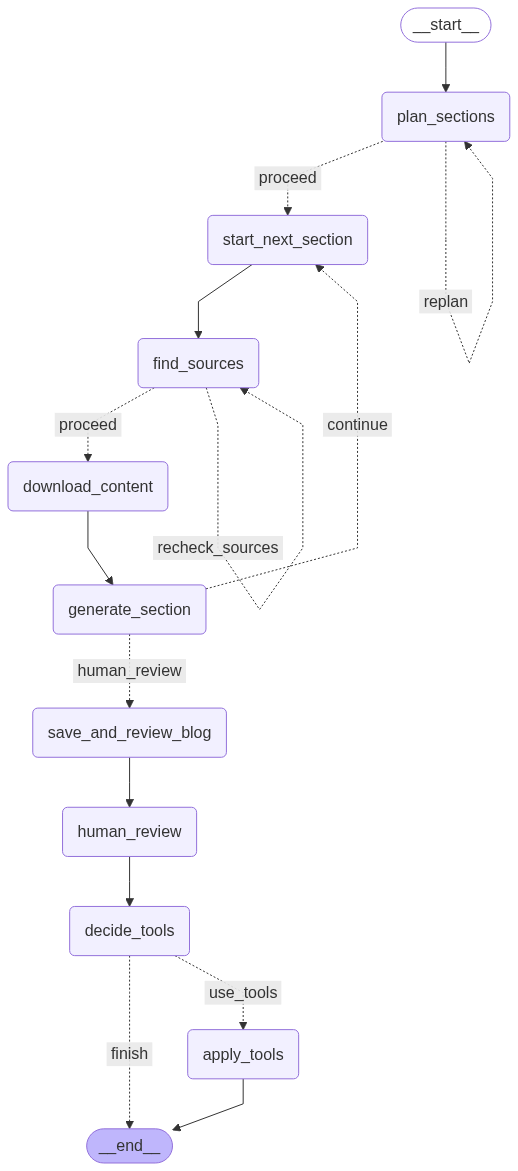

In [45]:
# Create the enhanced workflow graph
workflow = StateGraph(ResearchState)

# Add all nodes
workflow.add_node("plan_sections", plan_sections)
workflow.add_node("start_next_section", start_next_section)
workflow.add_node("find_sources", find_sources)
workflow.add_node("download_content", download_content)
workflow.add_node("generate_section", generate_section)
workflow.add_node("save_and_review_blog", save_and_review_blog)
workflow.add_node("human_review", lambda state: (wait_for_human_review(state), state)[1])
workflow.add_node("decide_tools", lambda state: (decide_tool_usage(state), state)[1])
workflow.add_node("apply_tools", apply_tools)

# Define edges
workflow.add_edge(START, "plan_sections")

workflow.add_conditional_edges(
    "plan_sections",
    approve_plan,
    {
        "proceed": "start_next_section",
        "replan": "plan_sections"
    }
)

workflow.add_edge("start_next_section", "find_sources")

workflow.add_conditional_edges(
    "find_sources",
    approve_sources,
    {
        "proceed": "download_content",
        "recheck_sources": "find_sources"
    }
)

workflow.add_edge("download_content", "generate_section")

workflow.add_conditional_edges(
    "generate_section",
    check_completion,
    {
        "continue": "start_next_section",
        "human_review": "save_and_review_blog"
    }
)

workflow.add_edge("save_and_review_blog", "human_review")
workflow.add_edge("human_review", "decide_tools")

workflow.add_conditional_edges(
    "decide_tools",
    decide_tool_usage,
    {
        "use_tools": "apply_tools",
        "finish": END
    }
)

workflow.add_edge("apply_tools", END)

# Compile the graph
research_graph = workflow.compile()

# Display the graph
display(Image(research_graph.get_graph().draw_mermaid_png()))

## Usage Example

In [46]:
def run_enhanced_research(topic: str):
    """
    Run the complete enhanced research workflow with human review and tools.
    
    Args:
        topic (str): Research topic
    """
    print(f"🚀 Starting enhanced research on: {topic}")
    print("This workflow includes:")
    print("  📝 Research and content generation")
    print("  👤 Human review and editing phase")
    print("  🛠️ Tool application (emoji replacement & code execution)")
    print()
    
    # Create initial state
    initial_state = create_initial_state(topic)
    
    # Run the workflow
    final_state = research_graph.invoke(initial_state)
    
    print(f"\n🎉 Enhanced research workflow complete!")
    if final_state.get("blog_file_path"):
        final_file = final_state["blog_file_path"].replace(".md", "_final.md")
        print(f"📄 Final output: {final_file}")
    
    return final_state

In [50]:
# Example: Run the enhanced research workflow
# Uncomment and modify the topic as needed

result = run_enhanced_research("History of Prussia")
print("\n" + "="*50)
print("WORKFLOW COMPLETED!")
print("="*50)

🚀 Starting enhanced research on: History of Prussia
This workflow includes:
  📝 Research and content generation
  👤 Human review and editing phase
  🛠️ Tool application (emoji replacement & code execution)

📋 Planned sections: ['Introduction', 'Section 1: The Early Years and the Duchy of Prussia', 'Section 2: The Rise of the Kingdom of Prussia', 'Section 3: The German Empire and the Great Powers', 'Conclusion']

📋 Proposed sections: ['Introduction', 'Section 1: The Early Years and the Duchy of Prussia', 'Section 2: The Rise of the Kingdom of Prussia', 'Section 3: The German Empire and the Great Powers', 'Conclusion']
📋 Planned sections: ['History of Prussia']

📋 Proposed sections: ['History of Prussia']

📝 Starting section: History of Prussia
🔍 Found 2 sources for 'History of Prussia'
  1. https://en.wikipedia.org/wiki/Prussia
  2. https://en.wikipedia.org/wiki/Kingdom_of_Prussia

🔍 Found sources:
  1. https://en.wikipedia.org/wiki/Prussia
  2. https://en.wikipedia.org/wiki/Kingdom_of_

In [48]:
stop

NameError: name 'stop' is not defined

## Tool Testing

You can test the individual tools here:

In [ ]:
# Test emoji tool
test_text_emoji = "This is amazing :smile: and I love it :fire: :star:"
result_emoji = add_emojis_tool(test_text_emoji)
print(f"Original: {test_text_emoji}")
print(f"With emojis: {result_emoji}")

In [ ]:
# Test code execution tool
test_text_code = """Here's some Python code:

```python
print("Hello from code execution!")
x = 2 + 2
print(f"2 + 2 = {x}")
```

And here's another example:

```python
import math
result = math.sqrt(16)
print(f"Square root of 16 is {result}")
```
"""

result_code = run_code_tool(test_text_code)
print(result_code)